<a href="https://colab.research.google.com/github/Hanzela634/Prediction-of-Lungs-Cancer/blob/main/lungs_cancer_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import Data**

In [1]:
%config Completer.use_jedi = False
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import seaborn as sns
import cv2
import random
import os
import imageio
import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
from collections import Counter

In [2]:
directory = r'/content/drive/MyDrive/archive/The IQ-OTHNCCD lung cancer dataset/The IQ-OTHNCCD lung cancer dataset'

categories = ['Bengin cases', 'Malignant cases', 'Normal cases']

**Image Size Variations**

In [3]:
size_data = {}
for category in categories:
    category_path = os.path.join(directory, category)
    class_index = categories.index(category)
    category_size_count = {}
    for file_name in os.listdir(category_path):
        file_path = os.path.join(category_path, file_name)
        height, width, channels = imageio.imread(file_path).shape
        size_key = f"{height} x {width}"
        if size_key in category_size_count:
            category_size_count[size_key] += 1
        else:
            category_size_count[size_key] = 1

    size_data[category] = category_size_count

size_data

<ipython-input-3-b7097d0ffa08>:8: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  height, width, channels = imageio.imread(file_path).shape


{'Bengin cases': {'512 x 512': 120},
 'Malignant cases': {'512 x 512': 501,
  '404 x 511': 1,
  '512 x 801': 28,
  '512 x 623': 31},
 'Normal cases': {'512 x 512': 415, '331 x 506': 1}}

Bengin cases


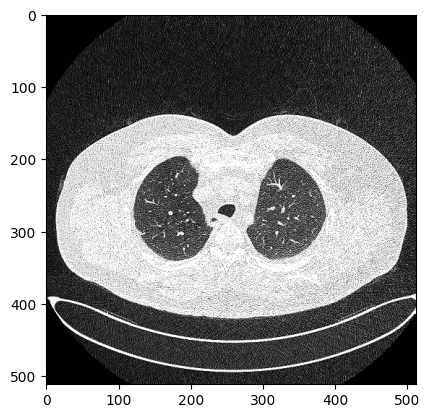

Malignant cases


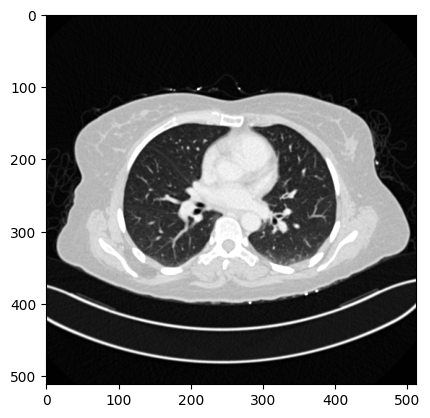

Normal cases


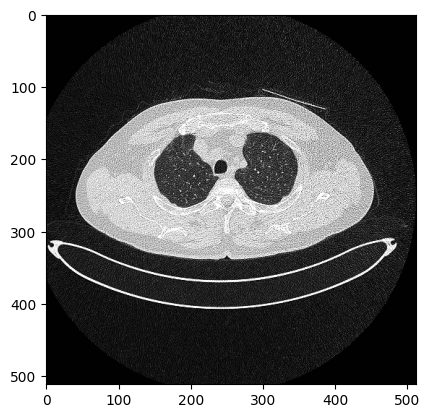

In [4]:
for category in categories:
    category_path = os.path.join(directory, category)
    class_index = categories.index(category)
    for file_name in os.listdir(category_path):
        file_path = os.path.join(category_path, file_name)
        print(category)
        image = cv2.imread(file_path, 0)
        plt.imshow(image, cmap='gray')
        plt.show()
        break

**Image Preprocessing and Testing**

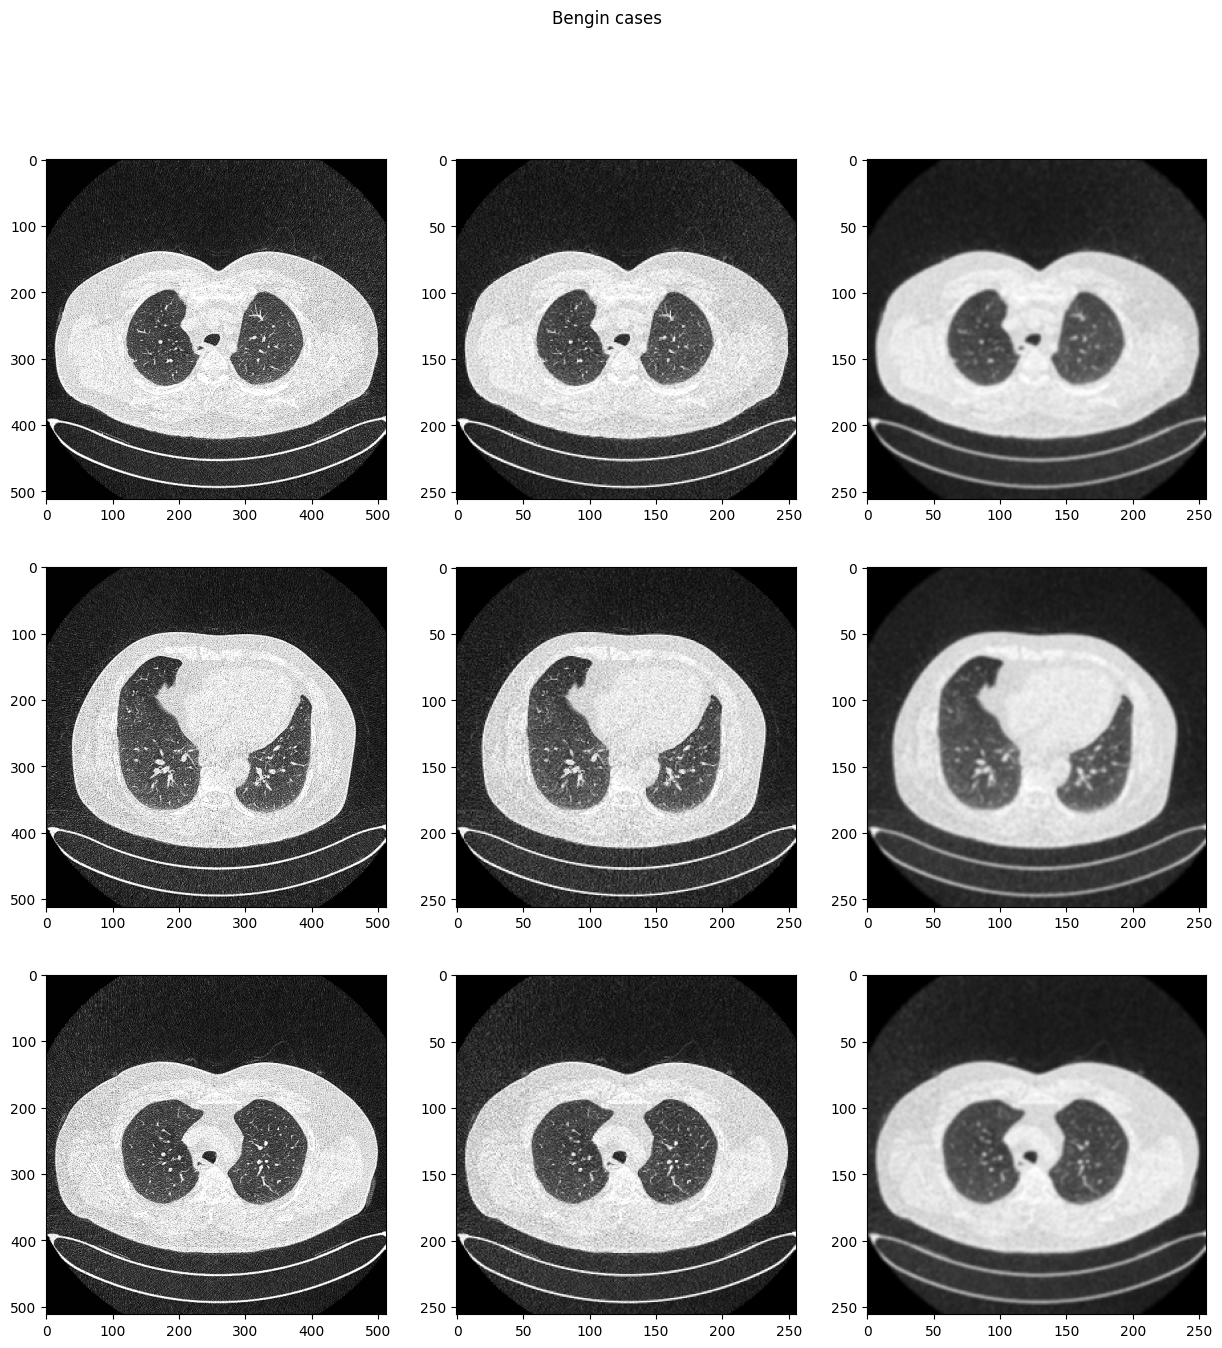

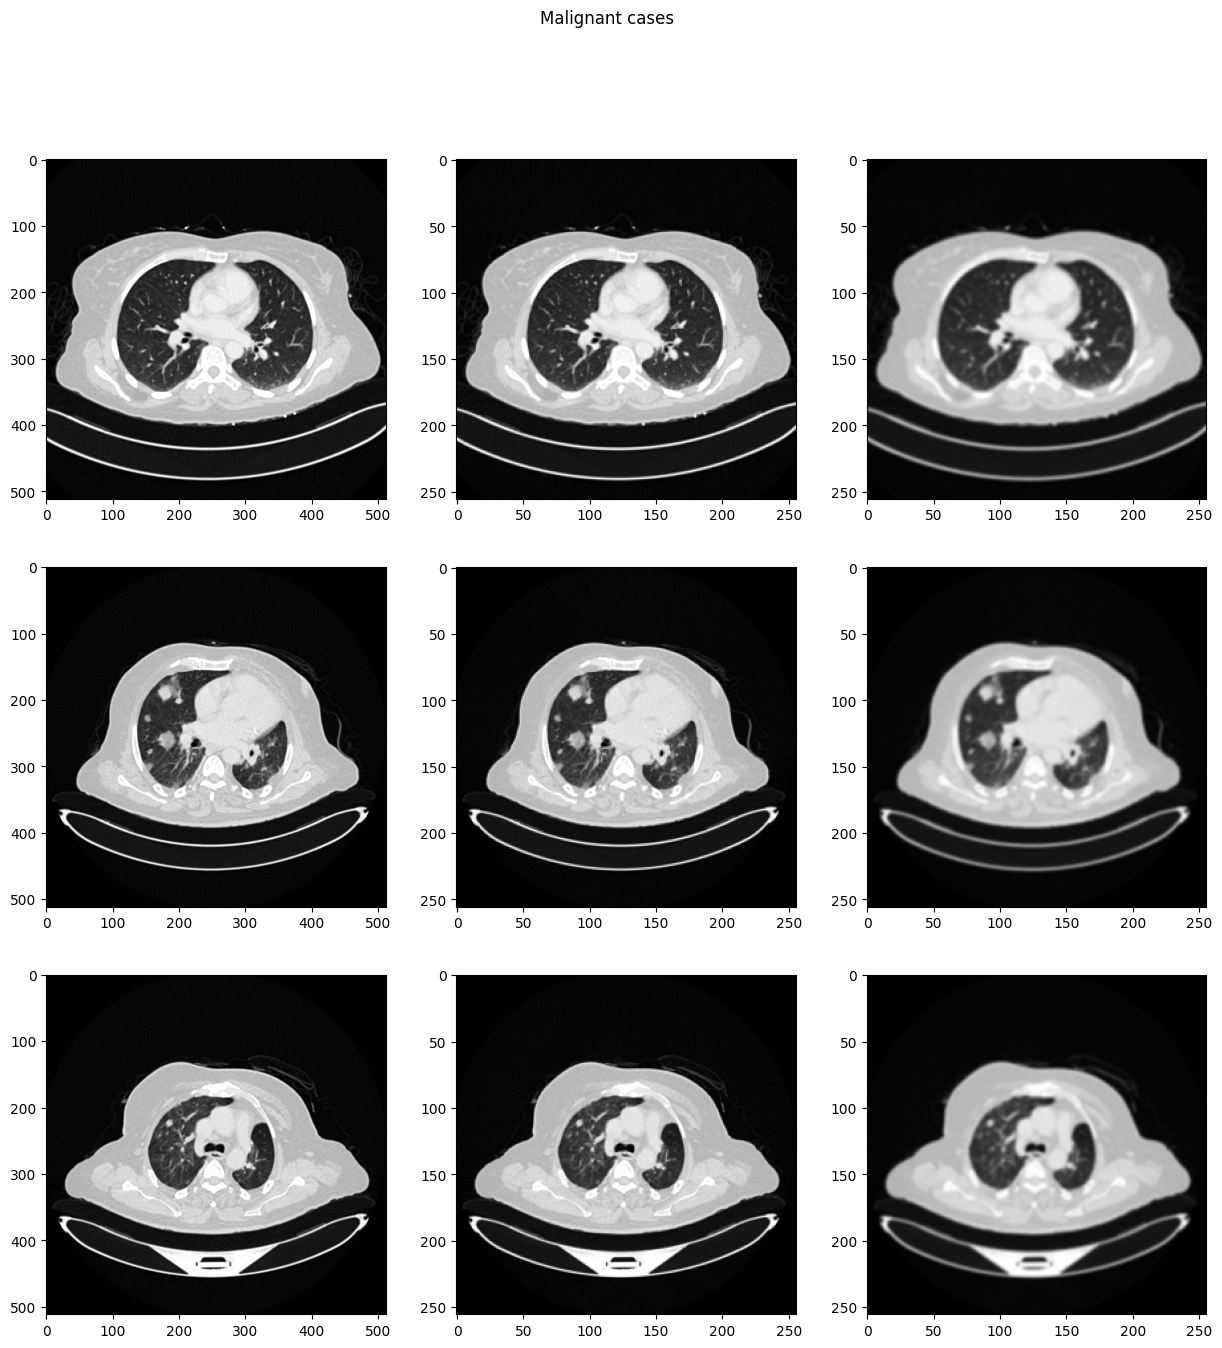

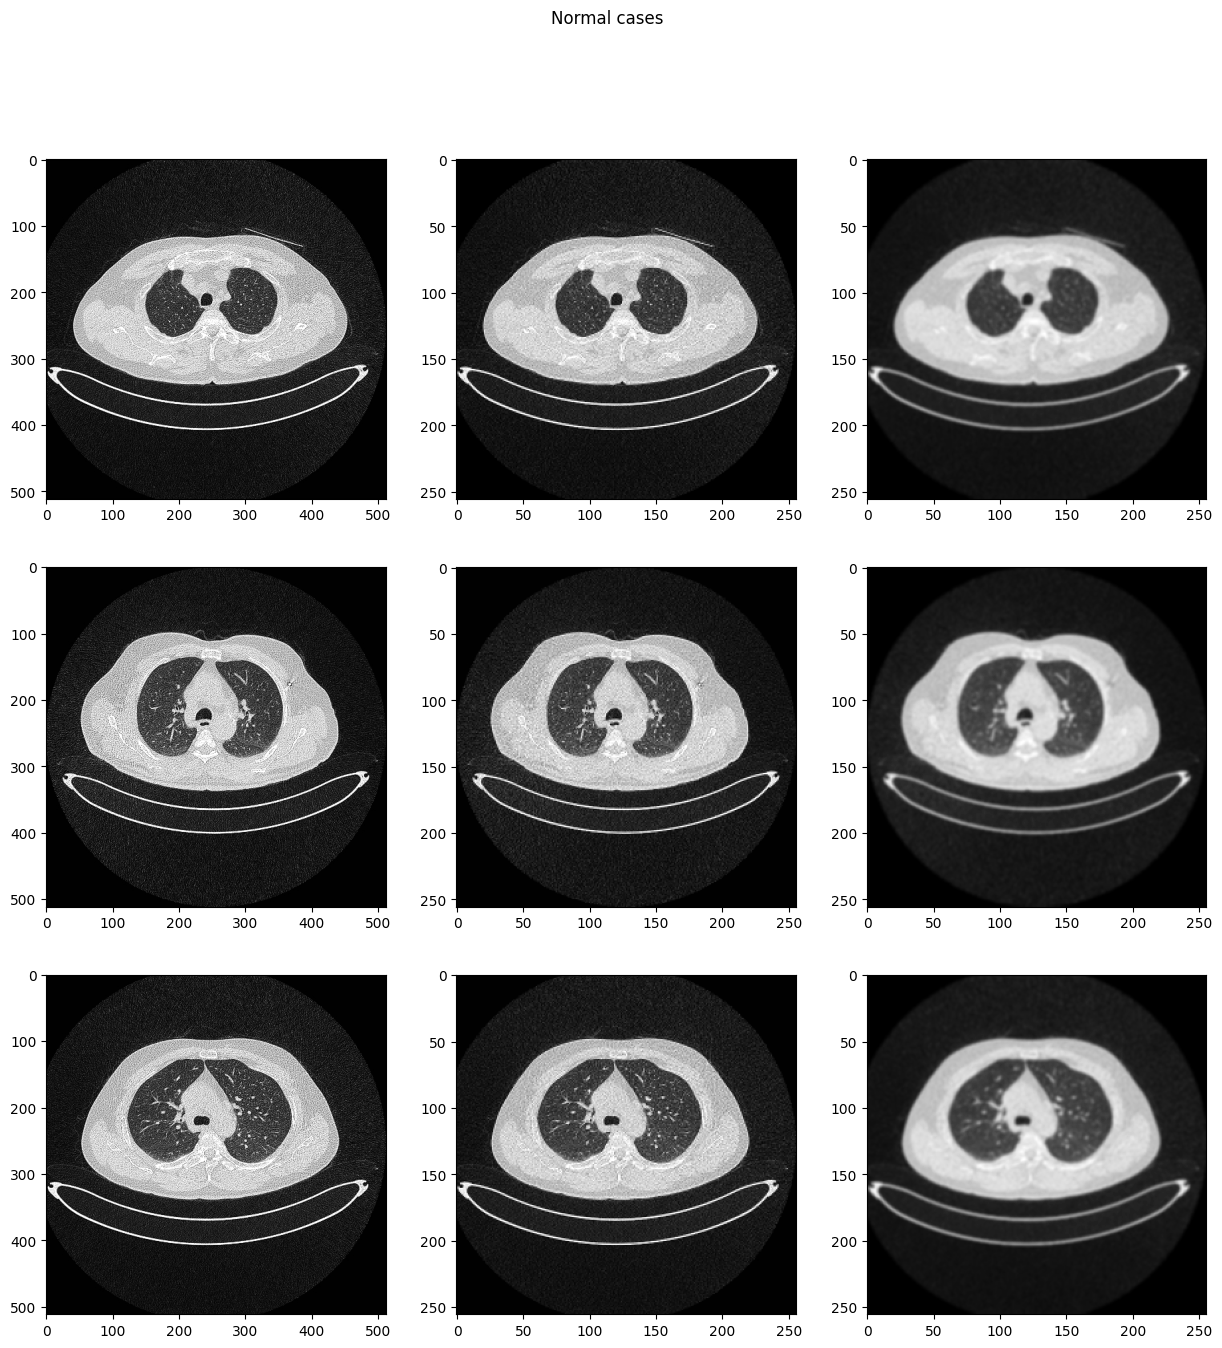

In [5]:
img_size = 256

for category in categories:
    sample_count, num_samples = 0, 3
    fig, ax = plt.subplots(num_samples, 3, figsize=(15, 15))
    fig.suptitle(category)

    category_path = os.path.join(directory, category)
    class_index = categories.index(category)

    for current_index, file_name in enumerate(os.listdir(category_path)):
        file_path = os.path.join(category_path, file_name)
        image = cv2.imread(file_path, 0)

        resized_image = cv2.resize(image, (img_size, img_size))

        blurred_image = cv2.GaussianBlur(resized_image, (5, 5), 0)

        ax[sample_count, 0].imshow(image, cmap='gray')
        ax[sample_count, 1].imshow(resized_image, cmap='gray')
        ax[sample_count, 2].imshow(blurred_image, cmap='gray')

        sample_count += 1
        if sample_count == num_samples:
            break

plt.show()

**Preparing Data**

In [6]:
data = []
img_size = 256

for category in categories:
    category_path = os.path.join(directory, category)
    class_index = categories.index(category)
    for file_name in os.listdir(category_path):
        file_path = os.path.join(category_path, file_name)
        image = cv2.imread(file_path, 0)
        # preprocess here
        resized_image = cv2.resize(image, (img_size, img_size))
        data.append([resized_image, class_index])

random.shuffle(data)

X, y = [], []
for features, label in data:
    X.append(features)
    y.append(label)

print('X length:', len(X))
print('y counts:', Counter(y))

# normalize
X = np.array(X).reshape(-1, img_size, img_size, 1)
X = X / 255.0
y = np.array(y)

X length: 1097
y counts: Counter({1: 561, 2: 416, 0: 120})


In [7]:
from sklearn.model_selection import train_test_split

# Split the data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, random_state=10, stratify=y
)

# Print the sizes and shapes of the training and validation sets
print(f'Training set size: {len(X_train)}, Shape: {X_train.shape}')
print(f'Validation set size: {len(X_valid)}, Shape: {X_valid.shape}')

Training set size: 822, Shape: (822, 256, 256, 1)
Validation set size: 275, Shape: (275, 256, 256, 1)


**Applying SMOTE to oversample the data**

In [8]:
print(Counter(y_train), Counter(y_valid))

Counter({1: 420, 2: 312, 0: 90}) Counter({1: 141, 2: 104, 0: 30})


In [9]:
# Assuming X_train is already defined and split
# Print the initial length and shape of X_train
print(f'Initial training set size: {len(X_train)}, shape: {X_train.shape}')

# Reshape X_train to have the desired dimensions
X_train_flattened = X_train.reshape(X_train.shape[0], img_size * img_size * 1)

# Print the updated length and shape of X_train
print(f'Flattened training set size: {len(X_train_flattened)}, shape: {X_train_flattened.shape}')


Initial training set size: 822, shape: (822, 256, 256, 1)
Flattened training set size: 822, shape: (822, 65536)


In [11]:
from collections import Counter
from imblearn.over_sampling import SMOTE
import numpy as np

# Example data setup (assuming X_train and y_train are already defined as numpy arrays)
# X_train = np.array([...])  # Should be a 4D array (num_samples, height, width, channels)
# y_train = np.array([...])  # Should be a 1D array (num_samples,)

# Print class distribution before applying SMOTE
print('Before SMOTE:', Counter(y_train))

# Reshape X_train from 4D to 2D
num_samples, height, width, channels = X_train.shape
X_train_reshaped = X_train.reshape(num_samples, height * width * channels)

# Initialize SMOTE
smote_sampler = SMOTE()

# Apply SMOTE to the training data
X_train_resampled, y_train_resampled = smote_sampler.fit_resample(X_train_reshaped, y_train)

# Print class distribution after applying SMOTE
print('After SMOTE:', Counter(y_train_resampled))

# Optionally, reshape X_train_resampled back to 4D if needed
X_train_resampled = X_train_resampled.reshape(-1, height, width, channels)



Before SMOTE: Counter({1: 420, 2: 312, 0: 90})
After SMOTE: Counter({2: 420, 1: 420, 0: 420})


In [12]:
# Reshape X_train and X_train_resampled
X_train = X_train.reshape(X_train.shape[0], img_size, img_size, 1)
X_train_resampled = X_train_resampled.reshape(X_train_resampled.shape[0], img_size, img_size, 1)

# Print the length and shape of X_train and X_train_resampled
print(f'Original training set size: {len(X_train)}, shape: {X_train.shape}')
print(f'Resampled training set size: {len(X_train_resampled)}, shape: {X_train_resampled.shape}')


Original training set size: 822, shape: (822, 256, 256, 1)
Resampled training set size: 1260, shape: (1260, 256, 256, 1)


**Model Building with SMOTE data**

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Activation, MaxPooling2D, Flatten, Dense

# Initialize the model
cnn_model = Sequential()

# Add the first convolutional layer
cnn_model.add(Conv2D(64, (3, 3), input_shape=X_train.shape[1:]))
cnn_model.add(Activation('relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))

# Add the second convolutional layer
cnn_model.add(Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the output and add dense layers
cnn_model.add(Flatten())
cnn_model.add(Dense(16))
cnn_model.add(Dense(3, activation='softmax'))

# Print the summary of the model
cnn_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 64)      640       
                                                                 
 activation (Activation)     (None, 254, 254, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 64)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 246016)            0

In [14]:
# Compile the CNN model
cnn_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)


In [15]:
# Fit the CNN model
training_history = cnn_model.fit(
    X_train_resampled, y_train_resampled,
    batch_size=8,
    epochs=10,
    validation_data=(X_valid, y_valid)
)

Epoch 1/10
158/158 [==============================] - 10s 30ms/step - loss: 0.5443 - accuracy: 0.8246 - val_loss: 0.0534 - val_accuracy: 0.9855
Epoch 2/10
158/158 [==============================] - 3s 21ms/step - loss: 0.0430 - accuracy: 0.9897 - val_loss: 0.0551 - val_accuracy: 0.9891
Epoch 3/10
158/158 [==============================] - 3s 21ms/step - loss: 0.0176 - accuracy: 0.9976 - val_loss: 0.0181 - val_accuracy: 0.9927
Epoch 4/10
158/158 [==============================] - 4s 22ms/step - loss: 0.0613 - accuracy: 0.9849 - val_loss: 0.0422 - val_accuracy: 0.9891
Epoch 5/10
158/158 [==============================] - 3s 21ms/step - loss: 0.0181 - accuracy: 0.9944 - val_loss: 0.0252 - val_accuracy: 0.9927
Epoch 6/10
158/158 [==============================] - 3s 21ms/step - loss: 0.0240 - accuracy: 0.9952 - val_loss: 0.0168 - val_accuracy: 0.9927
Epoch 7/10
158/158 [==============================] - 3s 20ms/step - loss: 0.0095 - accuracy: 0.9984 - val_loss: 0.0236 - val_accuracy: 0.985

**Results**

In [18]:
from sklearn.metrics import classification_report, confusion_matrix

# Make predictions on the validation set
y_predictions = cnn_model.predict(X_valid, verbose=1)

# Convert predictions to class labels
y_pred_classes = np.argmax(y_predictions, axis=1)

# Print the classification report
print(classification_report(y_valid, y_pred_classes))

# Print the confusion matrix
print(confusion_matrix(y_true=y_valid, y_pred=y_pred_classes))


9/9 [==============================] - 0s 35ms/step
              precision    recall  f1-score   support

           0       0.97      0.97      0.97        30
           1       1.00      0.99      0.99       141
           2       0.97      0.99      0.98       104

    accuracy                           0.99       275
   macro avg       0.98      0.98      0.98       275
weighted avg       0.99      0.99      0.99       275

[[ 29   0   1]
 [  0 139   2]
 [  1   0 103]]


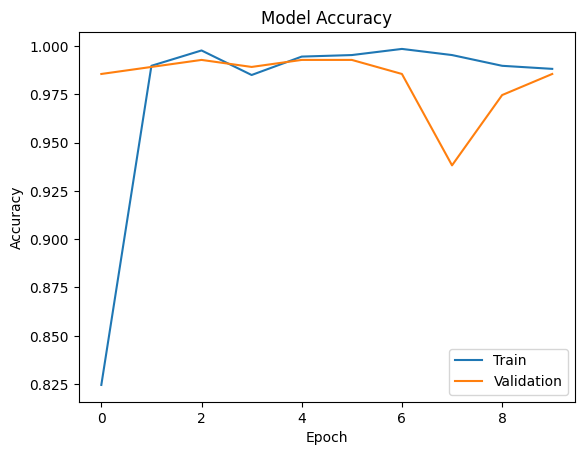

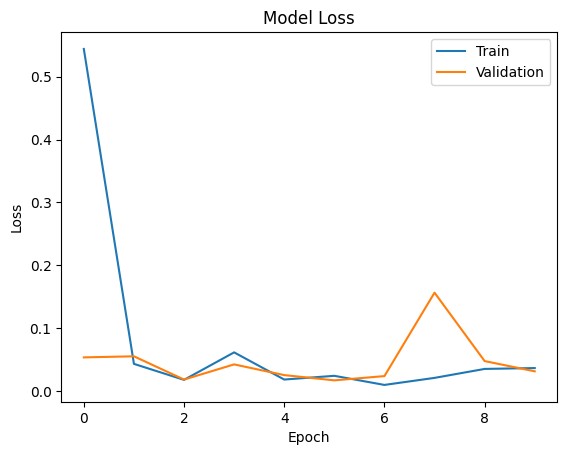

In [19]:
# Plot training and validation accuracy
plt.plot(training_history.history['accuracy'], label='Train')
plt.plot(training_history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(training_history.history['loss'], label='Train')
plt.plot(training_history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()